### **함수 정의**

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import numpy as np
from pandas.api.types import CategoricalDtype
warnings.filterwarnings(action='ignore')

############ 여기 두개 path만 바꿔서 돌리면 됩니다. ############

train_path = 'C:/Users/user/Desktop/VS code/test/태양광 대회/api_data/train_20221116.csv'
test_path = 'C:/Users/user/Desktop/VS code/test/태양광 대회/api_data/test_20221117.csv'
##############################################################

# quantiles = [0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.87]
quantiles = [0.8, 0.87]
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # 하이퍼파라미터 세팅
    
    # (a) Modeling
    seed = 42
    model = lgb.LGBMRegressor(objective='quantile', alpha=q,
                                boosting_type ='dart', # 다트 시도
                                n_estimators= 10000, # 커질수록 정교해짐(안정교해졌음)
                                num_leaves=18,
                                min_data_in_leaf = 35,
                                bagging_fraction=0.8, 
                                bagging_freq=10,
                                bagging_seed=seed,
                                feature_fraction=0.7,
                                feature_fraction_seed=seed,
                                learning_rate=1e-2,
                                random_seed=seed)

    # model = lgb.LGBMRegressor(objective='quantile', alpha=q, n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
    eval_set=[(X_valid, Y_valid)], early_stopping_rounds= 300, verbose= 500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(6)) # 여기에 라운드 추가 안해도됨
    return pred, model

def moving_avg_amount(base_df):
    base_df = base_df.sort_values(by = ['id','month','hour'])
    vin_df = pd.DataFrame(columns = base_df.columns)
    for id_num in range(0,21):
        base_df_one_id = base_df[base_df['id'] == id_num]
        base_df_one_id['amount_3days'] = base_df_one_id['amount'].rolling(window=3, min_periods = 1, closed = 'left').mean()
        base_df_one_id['amount_5days'] = base_df_one_id['amount'].rolling(window=5, min_periods = 1, closed = 'left').mean()
        vin_df = pd.concat([vin_df, base_df_one_id], axis = 0)
    vin_df = vin_df.sort_index()
    return vin_df

def train_data(X_train, y_train, X_valid, y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        pred , model = LGBM(q, X_train, y_train, X_valid, y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

def make_amount_mean(base_df, file_name):
    for idx in base_df.index:
        finding_data = base_df[(base_df['hour'] == base_df.loc[idx, 'hour']) & (base_df['id'] == base_df.loc[idx, 'id'])]
        
        # 3일 간격
        sum = 0
        count = 0
        for i in finding_data[finding_data.index < idx].tail(3)['amount']:
            sum += i
            count += 1
        if count != 0 :
            sum = sum / count
        base_df.loc[idx,'amount_3days'] = sum
        
        # 5일 간격
        sum2 = 0
        count2 = 0
        for i in finding_data[finding_data.index < idx].tail(5)['amount']:
            sum2 += i
            count2 += 1
        if count2 != 0 :
            sum2 = sum2 / count2
        base_df.loc[idx,'amount_5days'] = sum2
        
        if idx % 10000 == 0:
            print(idx)
    base_df.to_csv(file_name, index = False, encoding = 'utf-8-sig')
    return base_df
    
def lgbm_regressor(X_train, y_train, X_test, y_test):
    lgb_reg = lgb.LGBMRegressor(num_leaves=31, objective='quantile')
    lgb_reg.fit(X_train, y_train)
    y_pred = lgb_reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'mse : {mse}, r2 : {r2}')
    return y_pred

def column_maker(df):
    df['uv_mean']=0
    df['humidity_mean']=0
    df['temperature_mean']=0

    df_index=list(df['id'].unique())
    idx=[]
    for i in df_index:
        idx.append(int((df[df['id']==i].index).max()))

    df['uv_mean'][:idx[0]+1]=df['uv_idx'][:idx[0]+1].rolling(window=4, min_periods=1,closed='left').mean()
    df['humidity_mean'][:idx[0]+1]=df['humidity'][:idx[0]+1].rolling(window=4, min_periods=1,closed='left').mean()
    df['temperature_mean'][:idx[0]+1]=df['temperature'][:idx[0]+1].rolling(window=4, min_periods=1,closed='left').mean()
    for i in range(len(idx)-1):
        df['uv_mean'][idx[i]+1:idx[i+1]+1]=df['uv_idx'][idx[i]+1:idx[i+1]+1].rolling(window=4, min_periods=1,closed='left').mean()
        df['humidity_mean'][idx[i]+1:idx[i+1]+1]=df['humidity'][idx[i]+1:idx[i+1]+1].rolling(window=4, min_periods=1,closed='left').mean()
        df['temperature_mean'][idx[i]+1:idx[i+1]+1]=df['temperature'][idx[i]+1:idx[i+1]+1].rolling(window=4, min_periods=1,closed='left').mean()

    df.loc[0,'uv_mean']=df.loc[0,'uv_idx']
    df.loc[0,'humidity_mean']=df.loc[0,'humidity']
    df.loc[0,'temperature_mean']=df.loc[0,'temperature']
    for i in idx:
        if i==idx[-1]:
            break
        df.loc[i+1,'uv_mean']=df.loc[i+1,'uv_idx']
        df.loc[i+1,'humidity_mean']=df.loc[i+1,'humidity']
        df.loc[i+1,'temperature_mean']=df.loc[i+1,'temperature']
    return df

def sun_rising(hour):
    zero_list = [0,1,2,3,4,5,6,7,18,19,20,21,22,23]

    if hour in zero_list:
        return 0
    elif hour == 8:
        return 7
    elif hour == 9:
        return 17
    elif hour == 10:
        return 25
    elif hour == 11:
        return 30
    elif hour == 12:
        return 33
    elif hour == 13:
        return 32
    elif hour == 14:
        return 28
    elif hour == 15:
        return 21
    elif hour == 16:
        return 13
    elif hour == 17:
        return 2
def capa_level(x):
    if  x <= 50:
        return 1
    elif (x > 50) & (x <= 100):
        return 2
    elif (x > 100) & (x <= 400):
        return 3
    elif x > 400:
        return 4

### **train, test 통합**

In [2]:
#### train, test 통합

# train
train = pd.read_csv(train_path)
# train.drop(columns = 'index', inplace = True)

# test
test = pd.read_csv(test_path)
test.rename(columns = {'pressure_forecast' : 'pressure'}, inplace = True)

# concat
train_test_concat = pd.concat([train,test])
train_test_concat = train_test_concat.astype('float64')

### **이상치 제거 및 가공**

In [3]:
# uv_idx(자외선 지수)
train_test_concat = train_test_concat.drop(list(train_test_concat[train_test_concat['uv_idx'] > 11].index), axis = 0) # uv_idx 이상치제거

# capa_level(수용레벨)
train_test_concat['capa_level'] = train_test_concat['capacity'].apply(lambda x : capa_level(x)) # capacity 가공 후 capa_level 컬럼 생성
ord1 = CategoricalDtype(categories = [1,2,3,4], ordered = True)  # 순서 정렬
train_test_concat['capa_level'] = train_test_concat['capa_level'].astype(ord1) # 순서형 범주 입력

# # sun_rising(태양 고도)
# train_test_concat['sun_rising'] = train_test_concat['hour'].apply(lambda x : sun_rising(x))

In [4]:
use_col =  ['id', 
            'month', 
            'hour', 
            'season', 
            'temperature', 
            'humidity', 
            'dew_point', 
            'wind_dir',
            'wind_spd',
            'uv_idx',
            'visibility',
            'cloudiness',
            'ceiling',
            'pressure',
            'precip_1h',
            'capacity',
            'capa_level',
            'amount_3days',
            'amount_5days',
            'humidity_mean',
            'temperature_mean',
            'cos_time',
            'sin_time',
            'height',
            'amount']

category_dic = {'id': 'category',
                'month': 'category',
                'hour': 'category',
                'season': 'category'}

### **사용 컬럼 추출 및 로그화, train/valid/test 분리**

In [5]:
#### 사용 컬럼 추출
train_test_concat = train_test_concat[use_col]

#### 카테고리 타입 변경
train_test_concat = train_test_concat.astype(category_dic)
train_test_concat.dtypes

# 카테고리 타입 아닌 넘버형 컬럼 추출
con_col = []
for idx, i in enumerate(train_test_concat.dtypes):
    if i != 'category':
        con_col.append(train_test_concat.columns[idx])

# #### 넘버형 컬럼 로그화
# train_test_concat[con_col] = np.log1p(train_test_concat[con_col])

#### train / test 분리
X = train_test_concat[train_test_concat['amount'].isnull() == False].drop(columns = 'amount')
y = train_test_concat[train_test_concat['amount'].isnull() == False]['amount']
X_test = train_test_concat[train_test_concat['amount'].isnull()].drop(columns = 'amount')

#### train / valid 값 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2300)

In [6]:
X_test

,id,month,hour,season,temperature,humidity,dew_point,wind_dir,wind_spd,uv_idx,...,precip_1h,capacity,capa_level,amount_3days,amount_5days,humidity_mean,temperature_mean,cos_time,sin_time,height
0,0.0,11.0,0.0,3.0,6.11111,92.0,4.44444,330.0,5.63270,0.0,...,0.0,472.39,4,0.000000e+00,0.00,71.75,7.083335,1.000000e+00,0.000000e+00,-72.0
1,0.0,11.0,1.0,3.0,5.00000,97.0,4.44444,329.0,5.63270,0.0,...,0.0,472.39,4,0.000000e+00,0.00,78.50,6.944445,9.659258e-01,2.588190e-01,-69.0
2,0.0,11.0,2.0,3.0,5.00000,92.0,3.33333,88.0,3.70149,0.0,...,0.0,472.39,4,0.000000e+00,0.00,85.00,6.388890,8.660254e-01,5.000000e-01,-60.0
3,0.0,11.0,3.0,3.0,3.88889,92.0,2.77778,287.0,3.70149,0.0,...,0.0,472.39,4,0.000000e+00,0.00,90.50,5.694445,7.071068e-01,7.071068e-01,-49.0
4,0.0,11.0,4.0,3.0,5.00000,92.0,3.88889,332.0,3.70149,0.0,...,0.0,472.39,4,0.000000e+00,0.00,93.25,5.000000,5.000000e-01,8.660254e-01,-37.0
5,0.0,11.0,5.0,3.0,6.11111,93.0,5.00000,355.0,3.70149,0.0,...,0.0,472.39,4,0.000000e+00,0.00,93.25,4.722222,2.588190e-01,9.659258e-01,-25.0
6,0.0,11.0,6.0,3.0,7.22222,92.0,6.11111,18.0,3.70149,0.0,...,0.0,472.39,4,0.000000e+00,0.00,92.25,5.000000,6.123234e-17,1.000000e+00,-13.0
7,0.0,11.0,7.0,3.0,8.33333,89.0,6.66667,44.0,3.70149,0.0,...,0.0,472.39,4,0.000000e+00,0.00,92.25,5.555555,-2.588190e-01,9.659258e-01,-2.0
8,0.0,11.0,8.0,3.0,9.44444,85.0,7.22222,61.0,3.70149,1.0,...,0.0,472.39,4,8.866667e+00,6.74,91.50,6.666665,-5.000000e-01,8.660254e-01,8.0
9,0.0,11.0,9.0,3.0,10.55560,78.0,7.22222,67.0,3.70149,2.0,...,0.0,472.39,4,4.893333e+01,35.58,89.75,7.777775,-7.071068e-01,7.071068e-01,18.0


In [7]:
#### 모델 가동
lgbm_model, lgbm_data = train_data(X_train, y_train, X_valid, y_valid, X_test)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[500]	valid_0's quantile: 4.16614
[1000]	valid_0's quantile: 2.08114
[1500]	valid_0's quantile: 1.78616
[2000]	valid_0's quantile: 1.47967
[2500]	valid_0's quantile: 1.42327
[3000]	valid_0's quantile: 1.28203
[3500]	valid_0's quantile: 1.25841
[4000]	valid_0's quantile: 1.22454
[4500]	valid_0's quantile: 1.2297
[5000]	valid_0's quantile: 1.17092
[5500]	valid_0's quantile: 1.17471
[6000]	valid_0's quantile: 1.15687
[6500]	valid_0's quantile: 1.16048
[7000]	valid_0's quantile: 1.12763
[7500]	valid_0's quantile: 1.1051
[8000

In [8]:
#### summary 데이터 생성
summary = pd.DataFrame(columns = ['id','month','day','hour', 'upper', 'lower'])
summary['id'] = X_test['id']
summary['month'] = test['month']
summary['day'] = test['day']
summary['hour'] = X_test['hour']
# summary['upper'] = np.exp(lgbm_data.max(axis = 1)) - 1
# summary['lower'] = np.exp(lgbm_data.min(axis = 1)) - 1
summary['upper'] = lgbm_data.max(axis = 1)
summary['lower'] = lgbm_data.min(axis = 1)
# summary['real_amount'] = np.exp(y_test) - 1
summary.loc[summary['upper'] < 0 , 'upper'] = 0
summary.loc[summary['lower'] < 0 , 'lower'] = 0
summary = pd.concat([summary, lgbm_data], axis = 1)

#### 평균치가 0인 날짜에 대해 amount 0 처리
bbang_list = [0,1,2,3,4,5,6,19,20,21,22,23]
for idx , i in enumerate(summary['hour']):
    if i in bbang_list:
        summary.loc[idx,['upper','lower']] = 0
summary['upper'] = summary['upper'].round(6)
summary.to_csv('C:\\Users\\user\\Downloads\\predict20221118.csv', index = False, encoding = 'utf-8-sig')
summary

,id,month,day,hour,upper,lower,0.8,0.87
0,0.0,11,17,0.0,0.000000,0.000000,0.003842,0.006120
1,0.0,11,17,1.0,0.000000,0.000000,0.001459,0.003981
2,0.0,11,17,2.0,0.000000,0.000000,0.001781,0.003404
3,0.0,11,17,3.0,0.000000,0.000000,0.005296,0.005412
4,0.0,11,17,4.0,0.000000,0.000000,0.001051,0.006576
5,0.0,11,17,5.0,0.000000,0.000000,0.004074,0.010708
6,0.0,11,17,6.0,0.000000,0.000000,0.000305,0.005229
7,0.0,11,17,7.0,0.015788,0.008491,0.008491,0.015788
8,0.0,11,17,8.0,10.399497,9.868465,9.868465,10.399497
9,0.0,11,17,9.0,74.234721,68.940515,68.940515,74.234721


In [9]:
#### 예측모델 결과값
list_ = []
for idx in summary.index:
    dic = {}
    dic['upper'] = summary.loc[idx, 'upper']
    dic['lower'] = summary.loc[idx, 'lower']
    list_.append(dic)
list_

[{'upper': 0.0, 'lower': 0.0},
 {'upper': 0.0, 'lower': 0.0},
 {'upper': 0.0, 'lower': 0.0},
 {'upper': 0.0, 'lower': 0.0},
 {'upper': 0.0, 'lower': 0.0},
 {'upper': 0.0, 'lower': 0.0},
 {'upper': 0.0, 'lower': 0.0},
 {'upper': 0.015788, 'lower': 0.008491},
 {'upper': 10.399497, 'lower': 9.868465},
 {'upper': 74.234721, 'lower': 68.940515},
 {'upper': 164.828981, 'lower': 159.725315},
 {'upper': 261.165417, 'lower': 260.975114},
 {'upper': 308.110123, 'lower': 300.654246},
 {'upper': 309.897608, 'lower': 305.48327},
 {'upper': 286.379469, 'lower': 282.404556},
 {'upper': 241.66676, 'lower': 239.41636},
 {'upper': 161.410537, 'lower': 153.850163},
 {'upper': 51.959892, 'lower': 51.757213},
 {'upper': 5.977979, 'lower': 4.579246},
 {'upper': 0.0, 'lower': 0.0},
 {'upper': 0.0, 'lower': 0.0},
 {'upper': 0.0, 'lower': 0.0},
 {'upper': 0.0, 'lower': 0.0},
 {'upper': 0.0, 'lower': 0.0}]

In [10]:
summary

,id,month,day,hour,upper,lower,0.8,0.87
0,0.0,11,17,0.0,0.000000,0.000000,0.003842,0.006120
1,0.0,11,17,1.0,0.000000,0.000000,0.001459,0.003981
2,0.0,11,17,2.0,0.000000,0.000000,0.001781,0.003404
3,0.0,11,17,3.0,0.000000,0.000000,0.005296,0.005412
4,0.0,11,17,4.0,0.000000,0.000000,0.001051,0.006576
5,0.0,11,17,5.0,0.000000,0.000000,0.004074,0.010708
6,0.0,11,17,6.0,0.000000,0.000000,0.000305,0.005229
7,0.0,11,17,7.0,0.015788,0.008491,0.008491,0.015788
8,0.0,11,17,8.0,10.399497,9.868465,9.868465,10.399497
9,0.0,11,17,9.0,74.234721,68.940515,68.940515,74.234721


<AxesSubplot: xlabel='hour', ylabel='upper'>

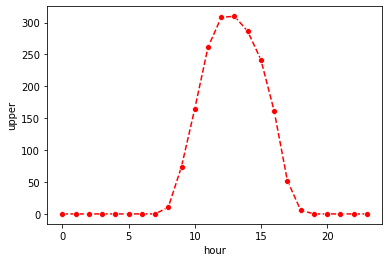

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import random
 
random.seed(100)
x = summary['hour']
y = summary['upper']
fig = plt.figure()
fig.set_facecolor('white')
# 선 그래프 한개 그리기
sns.lineplot(x=x, y=y, 
             color='r', # 색상
             linestyle='--', # 라인 스타일
             marker='o') # 마커